# Comparative study from hospitals (Brno)

<u>**Goal:**</u> Development of an Automated Machine Learning-based Model for Epileptogenic Zone Localization: A Comparative Study from Hospitals in Brno and Montreal

28/3/2023

## Data Preparation 

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from imblearn.over_sampling import SMOTE

# Import dataset
df = pd.read_csv('~/Marek/2_PhD/ISI/Work/data/new_isi_data.csv')

# Drop index column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Drop "nan" channels across all segments
df_nans = df[df.isnull().any(axis=1)]
for pts in df_nans.patient_id.unique():
    for chns in list(df_nans.loc[df_nans.patient_id == pts,'channel_name'].unique()):
        df = df.drop(df[(df.patient_id == pts) & (df.channel_name == chns)].index)

# Dataframe preparation, target column 
outcome_11 = 11
df = df[df.outcome <= outcome_11]
# Outcomes = [11, 12, 13, 14]
# df = df[df.outcome.isin(outcomes)]
mask = df.onset_channel == 'NON_SOZ'
df.loc[mask, 'onset_channel'] = 0
mask = df.onset_channel == 'SOZ'
df.loc[mask, 'onset_channel'] = 1

# Convert onset_channel column to numeric
df['onset_channel'] = pd.to_numeric(df['onset_channel'])
tmp = df['resected'].values * df['onset_channel'].values
df['target'] = tmp.astype(int)
df = df.rename(columns={'spike_rate':'spike_rate_0.0-0.0',
                        'pse':'pse_0.0-0.0',
                        'pac':'pac_0.0-0.0',
                        'fac':'fac_0.0-0.0',
                        'lfr':'lfr_0.0-0.0'})
features = [x for x in df if any(c.isdigit() for c in x)]
features.sort()

# Drop no target pts
target = 'target'
for pts in df.patient_id.unique():
    if sum(df.loc[df.patient_id == pts,target]) == 0:
        #print('patient',str(pts),'does not have target - droping this patient')
        df = df[df.patient_id != pts]

# Scale selected features with standard scaler (z-score)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder        
scaler = StandardScaler()
for pts in df.patient_id.unique(): 
    df.loc[df.patient_id == pts,features] = scaler.fit_transform(df.loc[df.patient_id == pts,features])

# Keep all segm_types
df = df.loc[df['segm_type'].isin([0,  1,  2,  3,  4,  8,  9, 10, 11, 12])]
#array([ 0,  1,  2,  3,  4,  8,  9, 10, 11, 12])
#df = df.loc[df['segm_type'] == 4]
#print(df.shape)

# Number of unique patients
#print(len(df.patient_id.unique()))
patients = df.patient_id.unique()
patients = np.sort(patients)

# Country column
df.loc[df['patient_id'] < 100 , 'country'] = 'Brno' 
df.loc[df['patient_id'] > 100 , 'country'] = 'Montreal' 

# Split epilepsy dataset to Montreal & Brno dataframe
df_montreal, df_brno = [x for _, x in df.groupby(df['patient_id'] < 100)]


# Select only the features and target, patient_id columns
# new_df_brno = df_brno.loc[:, features + ['target']]
new_df_brno = df_brno.loc[:, ['patient_id'] + features + ['target']]
new_df_montreal = df_montreal.loc[:, ['patient_id'] + features + ['target']]
print('Original dataset shape:', new_df_brno.shape)
print('Original dataset shape:', new_df_montreal.shape)
print('List of patients:', patients)


Original dataset shape: (16352, 62)
Original dataset shape: (14992, 62)
List of patients: [  61   63   71   77   82   89   93  583  657  717  723  953  965 1002
 1021 1041 1043 1630]


In [2]:
# Apply SMOTE to the patient_id, features and target variables in new_df_brno

from imblearn.over_sampling import SMOTE
import pandas as pd

# Define a list of patient IDs to loop over
patient_ids = [61, 63, 71, 77, 82, 89, 93]

# Create an empty list to store the resampled dataframes
resampled_dfs = []

# Loop over each patient ID and resample their data
for patient_id in patient_ids:
    # Select only rows with the current patient ID
    df_patient = new_df_brno.query('patient_id == @patient_id')

    # Separate the features and target variables
    X = df_patient.drop('target', axis=1)
    y = df_patient['target']

    # Define the SMOTE object and perform SMOTE on the data
    smote = SMOTE(k_neighbors=1)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Create a new dataframe with the resampled data and add the patient ID column
    resampled_df_patient = pd.DataFrame(X_resampled, columns=X.columns)
    resampled_df_patient['target'] = y_resampled
    resampled_df_patient['patient_id'] = patient_id

    # Append the resampled dataframe to the list
    resampled_dfs.append(resampled_df_patient)

# Concatenate all the resampled dataframes into a single dataframe
resampled_df_brno = pd.concat(resampled_dfs)

# Print the shape of the new dataframe
print('Resampled Brno dataframe shape:', resampled_df_brno.shape)


Resampled Brno dataframe shape: (31296, 62)


## Exploratory Data Analysis

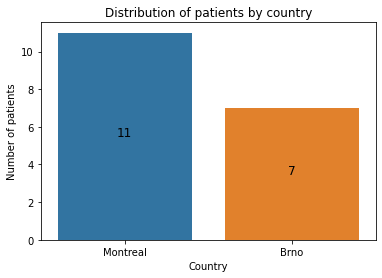

In [4]:
# Distribution of patients by country

sns.countplot(x='country', data=df.drop_duplicates(subset='patient_id'))
plt.title('Distribution of patients by country')
plt.xlabel('Country')
plt.ylabel('Number of patients')

# Get the count for each country
counts = df.drop_duplicates(subset='patient_id')['country'].value_counts()

# Add text labels to the top of each bar
for i, count in enumerate(counts):
    plt.annotate(str(count), xy=(i, count/2), ha='center', fontsize=12)

plt.show()

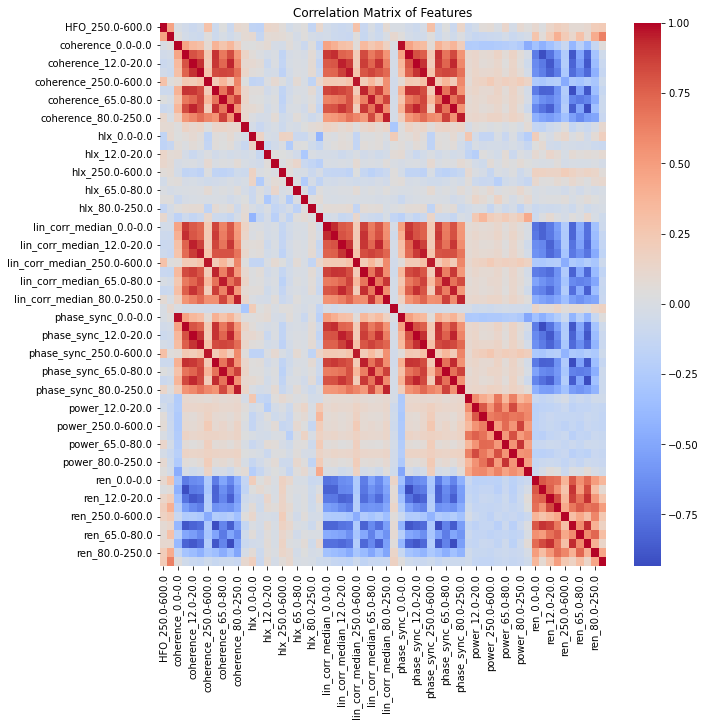

In [5]:
# Correlation Matrix of Features

# Generate correlation matrix
corr_matrix = df[features].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

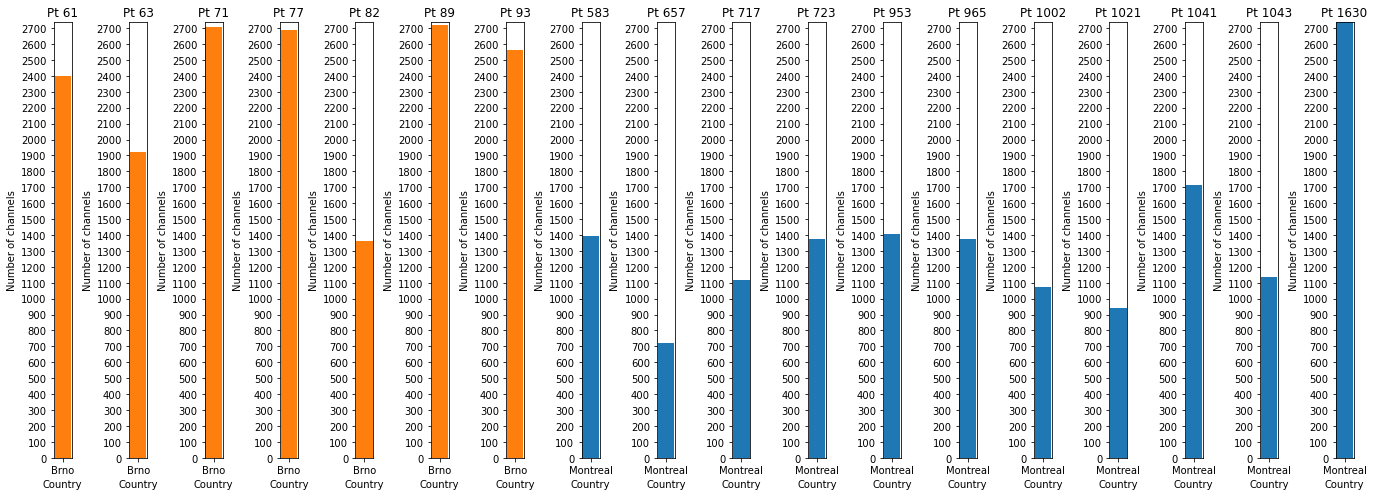

In [6]:
# Number of channels per patient and country 

import matplotlib.pyplot as plt
import pandas as pd

# Sort patient IDs from smaller to larger
patient_ids = sorted(df["patient_id"].unique())

# Create subplots for each patient horizontally next to each other
fig, axs = plt.subplots(1, len(patient_ids), figsize=(19, 7))

# Iterate over each patient ID and create a bar chart for their data
max_count = 0
for i, patient_id in enumerate(patient_ids):
    patient_data = df[df["patient_id"] == patient_id]
    grouped = patient_data.groupby("country").size().reset_index(name="count")
    ax = axs[i]
    
    # Set color of bars based on patient ID
    if patient_id < 100:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
    else:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
        
    ax.bar(grouped["country"], grouped["count"], color=color)
    
    ax.set_title(f"Pt {patient_id}")
    ax.set_xlabel("Country")
    ax.set_ylabel("Number of channels")
    max_count = max(max_count, grouped["count"].max())

# Set y-axis limits to be the same for all subplots
for ax in axs:
    ax.set_ylim(0, max_count)
    ax.set_yticks(range(0, max_count, 100))
    ax.set_yticklabels(range(0, max_count, 100))
   
    
plt.tight_layout()
plt.show()


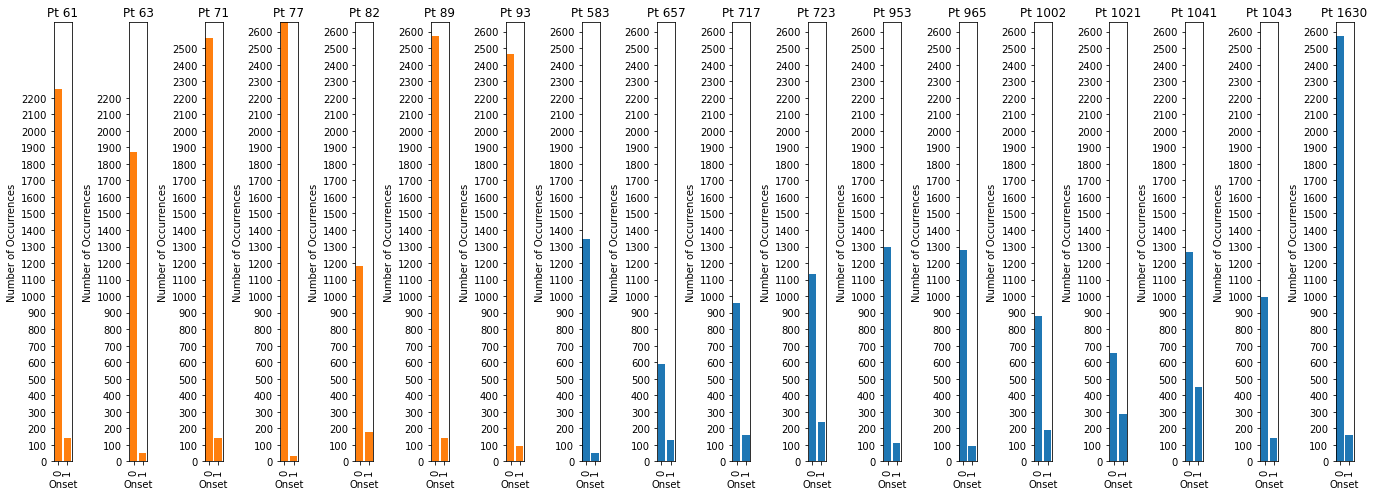

In [7]:
# Number of onset channels per patient per country 

import matplotlib.pyplot as plt
import pandas as pd

# Sort patient IDs from smaller to larger
patient_ids = sorted(df["patient_id"].unique())

# Create subplots for each patient horizontally next to each other
fig, axs = plt.subplots(1, len(patient_ids), figsize=(19, 7))

# Iterate over each patient ID and create a bar chart for their onset channel data
max_count = 0
for i, patient_id in enumerate(patient_ids):
    patient_data = df[df["patient_id"] == patient_id]
    grouped = patient_data.groupby("onset_channel").size().reset_index(name="count")
    ax = axs[i]
    
    # Set color of bars based on patient ID
    if patient_id < 100:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
    else:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
        
    # Convert the onset channel to categorical data type and specify a fixed width of 0.8
    ax.bar(grouped["onset_channel"], grouped["count"], width=0.8, color=color)
    
    ax.set_title(f"Pt {patient_id}")
    ax.set_xlabel("Onset")
    ax.set_ylabel("Number of Occurrences")
    
    # Rotate the x-axis labels by 90 degrees
    ax.tick_params(axis='x', rotation=90)
    
    max_count = max(max_count, grouped["count"].max())

    # Set y-axis tick marks and labels
    ax.set_ylim(0, max_count)
    ax.set_yticks(range(0, max_count, 100))
    ax.set_yticklabels(range(0, max_count, 100))

# Set y-axis limits to be the same for all subplots
for ax in axs:
    ax.set_ylim(0, max_count)

plt.tight_layout()
plt.show()

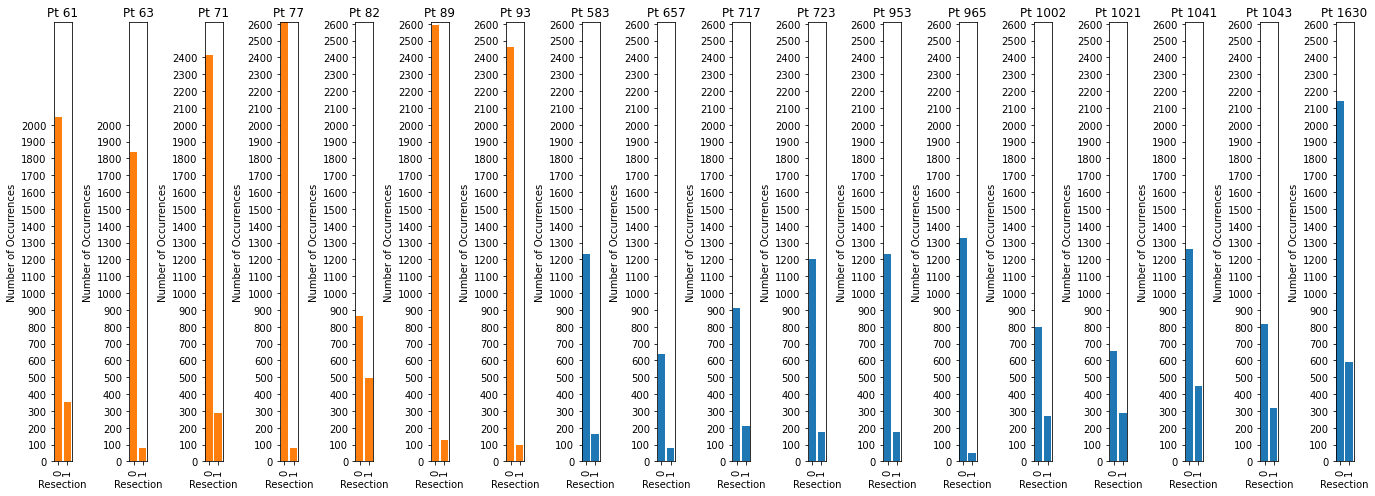

In [8]:
# Number of resection per patient per country 

import matplotlib.pyplot as plt
import pandas as pd

# Sort patient IDs from smaller to larger
patient_ids = sorted(df["patient_id"].unique())

# Create subplots for each patient horizontally next to each other
fig, axs = plt.subplots(1, len(patient_ids), figsize=(19, 7))

# Iterate over each patient ID and create a bar chart for their resected data
max_count = 0
for i, patient_id in enumerate(patient_ids):
    patient_data = df[df["patient_id"] == patient_id]
    grouped = patient_data.groupby("resected").size().reset_index(name="count")
    ax = axs[i]
    
    # Set color of bars based on patient ID
    if patient_id < 100:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
    else:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
        
    # Convert the resected variable to categorical data type and specify a fixed width of 0.8
    ax.bar(grouped["resected"], grouped["count"], width=0.8, color=color)
    
    ax.set_title(f"Pt {patient_id}")
    ax.set_xlabel("Resection")
    ax.set_ylabel("Number of Occurrences")
    
    # Rotate the x-axis labels by 90 degrees
    ax.tick_params(axis='x', rotation=90)
    
    max_count = max(max_count, grouped["count"].max())

    # Set y-axis tick marks and labels
    ax.set_ylim(0, max_count)
    ax.set_yticks(range(0, max_count, 100))
    ax.set_yticklabels(range(0, max_count, 100))

# Set y-axis limits to be the same for all subplots
for ax in axs:
    ax.set_ylim(0, max_count)

plt.tight_layout()
plt.show()

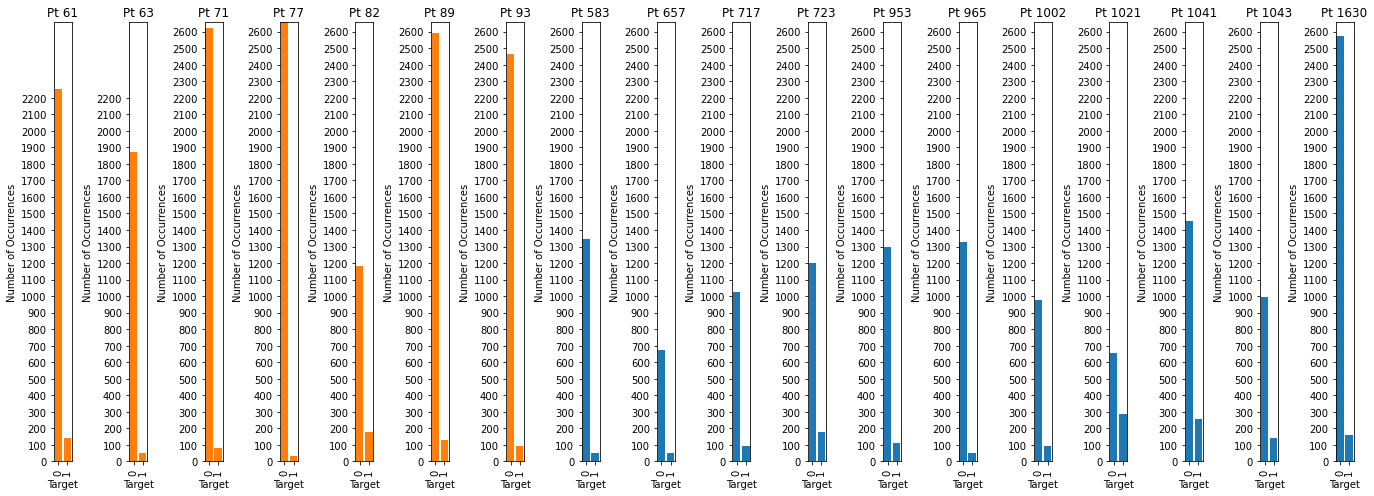

In [9]:
# Number of target values per patient per country 

import matplotlib.pyplot as plt
import pandas as pd

# Sort patient IDs from smaller to larger
patient_ids = sorted(df["patient_id"].unique())

# Create subplots for each patient horizontally next to each other
fig, axs = plt.subplots(1, len(patient_ids), figsize=(19, 7))

# Iterate over each patient ID and create a bar chart for their resected data
max_count = 0
for i, patient_id in enumerate(patient_ids):
    patient_data = df[df["patient_id"] == patient_id]
    grouped = patient_data.groupby("target").size().reset_index(name="count")
    ax = axs[i]
    
    # Set color of bars based on patient ID
    if patient_id < 100:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
    else:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
        
    # Convert the resected variable to categorical data type and specify a fixed width of 0.8
    ax.bar(grouped["target"], grouped["count"], width=0.8, color=color)
    
    ax.set_title(f"Pt {patient_id}")
    ax.set_xlabel("Target")
    ax.set_ylabel("Number of Occurrences")
    
    # Rotate the x-axis labels by 90 degrees
    ax.tick_params(axis='x', rotation=90)
    
    max_count = max(max_count, grouped["count"].max())

    # Set y-axis tick marks and labels
    ax.set_ylim(0, max_count)
    ax.set_yticks(range(0, max_count, 100))
    ax.set_yticklabels(range(0, max_count, 100))

# Set y-axis limits to be the same for all subplots
for ax in axs:
    ax.set_ylim(0, max_count)

plt.tight_layout()
plt.show()

## Comparative study of publicly available AutoML models (Brno dataset)

In [10]:
# Auto-Sklearn (An open-source library for AutoML using machine learning models)

# import necessary libraries
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
import autosklearn.classification

# load the data
resampled_df_brno

# separate features and target
X = resampled_df_brno.drop(['target'], axis=1)
y = resampled_df_brno['target']

# train the Auto-Sklearn model for each patient individually
for patient_id in resampled_df_brno['patient_id'].unique():
    
    # split the data into training and testing sets for the current patient
    X_train = X.loc[X['patient_id'] != patient_id]
    y_train = y.loc[X['patient_id'] != patient_id]
    X_test = X.loc[X['patient_id'] == patient_id]
    y_test = y.loc[X['patient_id'] == patient_id]

    # train the Auto-Sklearn model
    #clf = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=300, n_jobs=-1)
    clf = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=120, n_jobs=-1, ensemble_size=5, initial_configurations_via_metalearning=3)
    clf.fit(X_train, y_train)

    # evaluate the model
    y_pred = clf.predict(X_test)

    # calculate sensitivity, specificity, accuracy, and precision-recall curves
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)

    # calculate precision and recall
    precision_value = tp / (tp + fp)
    recall_value = tp / (tp + fn)

    # print the results for the current patient
    print("Results for patient", patient_id)
    print("Sensitivity:", round(sensitivity, 3))
    print("Specificity:", round(specificity, 3))
    print("Accuracy:", round(accuracy,3))
    print("Precision:", round(precision_value, 3))
    print("Recall:", round(recall_value, 3))
    print("Precision-Recall AUC:", round(pr_auc, 3))
    print()

[WARNING] [2023-03-27 12:16:50,876:Client-AutoML(1):6f753a0a-cc88-11ed-9051-57164b7c40ba] Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (119.626878)
[WARNING] [2023-03-27 12:16:50,876:Client-AutoML(1):6f753a0a-cc88-11ed-9051-57164b7c40ba] Capping the per_run_time_limit to 59.0 to have time for a least 2 models in each process.
Results for patient 61
Sensitivity: 0.111
Specificity: 0.991
Accuracy: 0.551
Precision: 0.926
Recall: 0.111
Precision-Recall AUC: 0.741

[WARNING] [2023-03-27 12:18:51,335:Client-AutoML(1):c4641ef8-cc88-11ed-9051-57164b7c40ba] Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (119.610305)
[WARNING] [2023-03-27 12:18:51,335:Client-AutoML(1):c4641ef8-cc88-11ed-9051-57164b7c40ba] Capping the per_run_time_limit to 59.0 to have time for a least 2 models in each process.
Results for patient 63
Sensitivity: 0.099

In [11]:
# Auto-Keras (An open-source library for performing AutoML for deep learning models) 

# import necessary libraries
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
import autokeras as ak

# load the data
resampled_df_brno


# separate features and target
X = resampled_df_brno.drop(['target'], axis=1)
y = resampled_df_brno['target']

# train the AutoKeras model for each patient individually
for patient_id in resampled_df_brno['patient_id'].unique():
    
    # split the data into training and testing sets for the current patient
    X_train = X.loc[X['patient_id'] != patient_id]
    y_train = y.loc[X['patient_id'] != patient_id]
    X_test = X.loc[X['patient_id'] == patient_id]
    y_test = y.loc[X['patient_id'] == patient_id]

    # train the AutoKeras model
    clf = ak.AutoModel(
        inputs=ak.StructuredDataInput(),
        outputs=[ak.ClassificationHead(loss='binary_crossentropy', metrics=['accuracy'])],
        directory='auto_model',
        seed=123,
        max_trials=5)
    clf.fit(X_train, y_train)

    # evaluate the model
    y_pred = clf.predict(X_test)

    # calculate sensitivity, specificity, accuracy, and precision-recall curves
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)

    # calculate precision and recall
    precision_value = tp / (tp + fp)
    recall_value = tp / (tp + fn)

    # print the results for the current patient
    print("Results for patient", patient_id)
    print("Sensitivity:", round(sensitivity, 3))
    print("Specificity:", round(specificity, 3))
    print("Accuracy:", round(accuracy,3))
    print("Precision:", round(precision_value, 3))
    print("Recall:", round(recall_value, 3))
    print("Precision-Recall AUC:", round(pr_auc, 3))
    print()


Trial 5 Complete [00h 00m 28s]
val_loss: 0.6391558051109314

Best val_loss So Far: 0.6391558051109314
Total elapsed time: 00h 02m 12s
141/141 [==============================] - 0s 2ms/step
Results for patient 61
Sensitivity: 0.891
Specificity: 0.039
Accuracy: 0.465
Precision: 0.481
Recall: 0.891
Precision-Recall AUC: 0.713

117/117 [==============================] - 0s 2ms/step
Results for patient 63
Sensitivity: 1.0
Specificity: 0.01
Accuracy: 0.505
Precision: 0.502
Recall: 1.0
Precision-Recall AUC: 0.751

164/164 [==============================] - 0s 2ms/step
Results for patient 71
Sensitivity: 0.923
Specificity: 0.103
Accuracy: 0.513
Precision: 0.507
Recall: 0.923
Precision-Recall AUC: 0.734

166/166 [==============================] - 0s 2ms/step
Results for patient 77
Sensitivity: 1.0
Specificity: 0.017
Accuracy: 0.509
Precision: 0.504
Recall: 1.0
Precision-Recall AUC: 0.752

74/74 [==============================] - 0s 2ms/step
Results for patient 82
Sensitivity: 0.95
Specificity: 

In [14]:
# TPOT (A python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming)

# import necessary libraries
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
from tpot import TPOTClassifier

# load the data
resampled_df_brno

# separate features and target
X = resampled_df_brno.drop(['target'], axis=1)
y = resampled_df_brno['target']

# train the TPOT model for each patient individually
for patient_id in resampled_df_brno['patient_id'].unique():
    
    # split the data into training and testing sets for the current patient
    X_train = X.loc[X['patient_id'] != patient_id]
    y_train = y.loc[X['patient_id'] != patient_id]
    X_test = X.loc[X['patient_id'] == patient_id]
    y_test = y.loc[X['patient_id'] == patient_id]

    # train the TPOT model
    clf = TPOTClassifier(generations=3, population_size=10, cv=5, verbosity=2, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)

    # evaluate the model
    y_pred = clf.predict(X_test)

    # calculate sensitivity, specificity, accuracy, and precision-recall curves
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)

    # calculate precision and recall
    precision_value = tp / (tp + fp)
    recall_value = tp / (tp + fn)

    # print the results for the current patient
    print("Results for patient", patient_id)
    print("Sensitivity:", round(sensitivity, 3))
    print("Specificity:", round(specificity, 3))
    print("Accuracy:", round(accuracy,3))
    print("Precision:", round(precision_value, 3))
    print("Recall:", round(recall_value, 3))
    print("Precision-Recall AUC:", round(pr_auc, 3))
    print()


Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Best pipeline: KNeighborsClassifier(Normalizer(input_matrix, norm=l1), n_neighbors=3, p=1, weights=distance)
Results for patient 61
Sensitivity: 0.109
Specificity: 0.953
Accuracy: 0.531
Precision: 0.698
Recall: 0.109
Precision-Recall AUC: 0.626


Generation 1 - Current best internal CV score: 0.832129201314425

Generation 2 - Current best internal CV score: 0.832129201314425

Generation 3 - Current best internal CV score: 0.832129201314425

Best pipeline: KNeighborsClassifier(Normalizer(input_matrix, norm=l1), n_neighbors=3, p=1, weights=distance)
Results for patient 61
Sensitivity: 0.109
Specificity: 0.953
Accuracy: 0.531
Precision: 0.698
Recall: 0.109
Precision-Recall AUC: 0.626



Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Best pipeline: ExtraTreesClassifier(VarianceThreshold(input_matrix, threshold=0.001), bootstrap=False, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=6, min_samples_split=5, n_estimators=100)
Results for patient 71
Sensitivity: 0.0
Specificity: 0.992
Accuracy: 0.496
Precision: 0.0
Recall: 0.0
Precision-Recall AUC: 0.25


Generation 1 - Current best internal CV score: 0.8173650455235378

Best pipeline: KNeighborsClassifier(Normalizer(input_matrix, norm=l1), n_neighbors=3, p=1, weights=distance)
Results for patient 63
Sensitivity: 0.495
Specificity: 0.92
Accuracy: 0.707
Precision: 0.861
Recall: 0.495
Precision-Recall AUC: 0.804


Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.7500000000000001, min_samples_leaf=5, min_samples_split=9, n_estimators=100)
Results for patient 77
Sensitivity: 0.084
Specificity: 0.994
Accuracy: 0.539
Precision: 0.933
Recall: 0.084
Precision-Recall AUC: 0.737


Generation 2 - Current b

Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7811659577823559

Generation 2 - Current best internal CV score: 0.7814728457943564

Generation 3 - Current best internal CV score: 0.7832022164502676

Best pipeline: KNeighborsClassifier(Binarizer(input_matrix, threshold=0.4), n_neighbors=3, p=1, weights=distance)
Results for patient 71
Sensitivity: 0.225
Specificity: 0.926
Accuracy: 0.575
Precision: 0.753
Recall: 0.225
Precision-Recall AUC: 0.682



Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=80, p=1, weights=distance)
Results for patient 89
Sensitivity: 0.151
Specificity: 0.745
Accuracy: 0.448
Precision: 0.372
Recall: 0.151
Precision-Recall AUC: 0.474


Generation 1 - Current best internal CV score: 0.7808951039586851

Generation 2 - Current best internal CV score: 0.7808951039586851

Generation 3 - Current best internal CV score: 0.7927869723502174

Best pipeline: KNeighborsClassifier(BernoulliNB(ExtraTreesClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=1.0, min_samples_leaf=3, min_samples_split=9, n_estimators=100), alpha=1.0, fit_prior=False), n_neighbors=3, p=1, weights=distance)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


Results for patient 77
Sensitivity: 0.241
Specificity: 0.977
Accuracy: 0.609
Precision: 0.913
Recall: 0.241
Precision-Recall AUC: 0.767



Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8329239026876486

Generation 2 - Current best internal CV score: 0.8345503183107319

Generation 3 - Current best internal CV score: 0.8355876267962395

Best pipeline: KNeighborsClassifier(LogisticRegression(GradientBoostingClassifier(input_matrix, learning_rate=0.01, max_depth=5, max_features=0.15000000000000002, min_samples_leaf=8, min_samples_split=5, n_estimators=100, subsample=0.45), C=0.1, dual=False, penalty=l2), n_neighbors=95, p=1, weights=distance)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


Results for patient 82
Sensitivity: 0.208
Specificity: 0.895
Accuracy: 0.552
Precision: 0.665
Recall: 0.208
Precision-Recall AUC: 0.634



Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8205824956096363

Generation 2 - Current best internal CV score: 0.8295827026161355

Generation 3 - Current best internal CV score: 0.8295827026161355

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=21, p=1, weights=distance)
Results for patient 89
Sensitivity: 0.052
Specificity: 0.841
Accuracy: 0.447
Precision: 0.248
Recall: 0.052
Precision-Recall AUC: 0.387



Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8077160563746553

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=3, p=1, weights=distance)
Results for patient 82
Sensitivity: 0.101
Specificity: 0.973
Accuracy: 0.537
Precision: 0.789
Recall: 0.101
Precision-Recall AUC: 0.67


Generation 2 - Current best internal CV score: 0.8077160563746553

Generation 3 - Current best internal CV score: 0.8077160563746553

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=3, p=1, weights=distance)
Results for patient 93
Sensitivity: 0.148
Specificity: 0.914
Accuracy: 0.531
Precision: 0.634
Recall: 0.148
Precision-Recall AUC: 0.604



In [15]:
# H2O's AutoML (Automating the machine learning workflow)

import h2o
from h2o.automl import H2OAutoML
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix

# Initialize h2o
h2o.init()

# Convert pandas dataframe to H2OFrame
resampled_df_brno = h2o.H2OFrame(df)

# Convert patient_id & target variable to categorical
resampled_df_brno['target'] = resampled_df_brno['target'].asfactor()
resampled_df_brno['patient_id'] = resampled_df_brno['patient_id'].asfactor()

# Define target and feature variables
target = "target"
features = list(features)

# Convert numpy ndarray to list of strings
patients = [61, 63, 71, 77, 82, 89, 93]
patients = list(map(str, patients))

for patient in patients:
    # Create a patient mask to filter out the current patient
    patient_mask = resampled_df_brno['patient_id'] != patient
    
    # Create a new train and test dataframe with the patient left out
    train_df = resampled_df_brno[patient_mask]
    test_df = resampled_df_brno[resampled_df_brno['patient_id'] == patient]
    
    # Define target and feature variables
    y = target
    X = features
    
    # Run AutoML on the filtered train set
    aml = H2OAutoML(max_models=10, seed=1)
    aml.train(x=X, y=y, training_frame=train_df)
    
    # Get the best model
    best_model = aml.leader
    
    # Make predictions on the test set
    #predictions = best_model.predict(test_df)
    
    # Get the predicted target values and actual target values
    y_pred = best_model.predict(test_df).as_data_frame()['predict'].values
    y_true = test_df[target].as_data_frame().values.flatten()

    # Calculate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate sensitivity, specificity, accuracy, precision, and recall
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision_value = tp / (tp + fp)
    recall_value = tp / (tp + fn)

    # Calculate precision-recall AUC
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    # Print the evaluation results for the current patient
    print("Patient ID: ", patient)
    print("Model Leader: ", best_model.model_id)
    print("Sensitivity: ", round(sensitivity, 3))
    print("Specificity: ", round(specificity, 3))
    print("Accuracy: ", round(accuracy, 3))
    print("Precision: ", round(precision_value, 3))
    print("Recall: ", round(recall_value, 3))
    print("Precision-Recall AUC: ", round(pr_auc, 3))
    print("-----------------------------")
    

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.18" 2023-01-17; OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /home/marek/.local/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpk9lqtmtr
  JVM stdout: /tmp/tmpk9lqtmtr/h2o_marek_started_from_python.out
  JVM stderr: /tmp/tmpk9lqtmtr/h2o_marek_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,2 months and 21 days
H2O_cluster_name:,H2O_from_python_marek_udp3ao
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.742 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |██
Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=3, p=1, weights=distance)
Results for patient 93
Sensitivity: 0.148
Specificity: 0.914
Accuracy: 0.531
Precision: 0.634
Recall: 0.148
Precision-Recall AUC: 0.604

█████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Patient ID:  61
Model Leader:  StackedEnsemble_AllModels_1_AutoML_1_20230327_151950
Sensitivity:  0.042
Specificity:  0.987
Accuracy:  0.93
Precision:  0.171
Recall:  0.042
Precision-Recall AUC:  0.135
-----------------------------
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Patient ID:  63
Model Leader:  StackedEnsemble_AllModels_1_AutoML_2